<a target="_blank" href="https://colab.research.google.com/github/IngCarlaPezzone/MI_PROYECTO_Clasificador_de_Texto_NLP_FastAPI/blob/main/Clasificador_Textos_NLP.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Clasificador de Textos usando NLP

A continuación, se explican los pasos realizados para entrenar un modelo con NLP que predice la categoría a la que pertence un determinado texto.


## Importaciones y descargas necesarias

In [ ]:
# Importaciones a usar
import os
import shutil
import re
import glob

import numpy as np
import pandas as pd
import json

from bs4 import BeautifulSoup
import requests
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import matplotlib.pyplot as plt

# Descargas necesarias
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Conectar con colab
from google.colab import drive
drive.mount('/content/drive')

# Cambiar al directorio de trabajo
os.chdir('/content/drive/MyDrive/Clasificador_textos') # <--- Modificar a su ubicación del proyecto

# Verifica la ubicación actual
!pwd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive
/content/drive/MyDrive/Clasificador_textos


## Creación del conjunto de datos

### Creación del listado de URL para armar el conjunto de datos

En primer lugar se necesita crear el archivo `DataSet.csv` que se puede crear con ChatGPT. Por ejemplo, para este proyecto se utilizó el siguiente prompt para solicitar un listado de URL por temas de interés:

"*Sos un machine learning developer, y estas haciendo un data set para una clasificación de texto. Necesitas armar el conjunto de datos. Necesito que me des 50 links de wikipedia en ingles, relacionados con el tema Meteorología.
Me los tenes que dar en formato csv con dos columnas, la primera con las URL y la segunda con la Clase, que en este caso sería Meteorology.*"

Solicitarle continuar la respuesta hasta que finalice de escribir las URL, si fuera necesario. Cuando finalice, se le puede decir:

"*Dame lo mismo para biologia*"

De esta manera, se puede solicitar todas las categorías de interés. Para este proyecto se usaron: Meteorología, Biología y Deporte.

Guardar todos los links que proporciona ChatGPT en un solo archivo .csv con la precaución de nombrar las columnas como URL y Clase.

### Creación del DataFrame con los textos extraídos de las URL


Con la función `obtener_registros_por_parrafo` se recorre el archivo `DataSet.csv`, obtiene los textos ubicados entre etiquetas `<p>` y los guarda en un DataFrame llamado `registros_df`.



In [7]:
def obtener_registros_por_parrafo(archivo):
    '''
    Permite abrir un archivo .csv que contiene una columna con las URL desde donde se quiere extrae textos y
    otra columna con las Clase (categoría) a la que pertenece ese texto.
    La función recorre cada URL y toma el texto que se encuentra en las etiquetas <p>.
    Finalmente lo guarda en un DataFrame de pandas.
    '''
    # Lee el archivo de CSV con pandas
    df = pd.read_csv(archivo, encoding='latin1')

    # Lista vacía para guardar los registros
    registros = []

    # Itera sobre cada registro del df
    for _, row in df.iterrows():
        url = row["URL"]
        clase = row["Clase"]

        # Toma los parrafos si es que la URL funciona
        req = requests.get(url)
        if req.status_code == 200:
            html = BeautifulSoup(req.text, "html.parser")
            parrafos = [para.text for para in html.find_all("p")]

            for parrafo in parrafos:
                # Divide el párrafo en sentencias usando los saltos de línea
                sentencias = parrafo.split('\n')

                for sentencia in sentencias:
                    # Elimina espacios en blanco al inicio y final de la sentencia
                    sentencia = sentencia.strip()

                    # Agrega un registro por cada sentencia conservando la URL y la clase
                    registros.append({"URL": url, "Clase": clase, "Sentencia": sentencia})

    # Crea el DtaFrame final con los registros obtenidos
    registros_df = pd.DataFrame(registros)
    return registros_df


In [8]:
# Ejecutamos la función y visualizamos el DataFrame
archivo = "./DataSet.csv"
df_registros = obtener_registros_por_parrafo(archivo)
df_registros

,URL,Clase,Sentencia
0,https://en.wikipedia.org/wiki/Meteorology,Meteorology,
1,https://en.wikipedia.org/wiki/Meteorology,Meteorology,
2,https://en.wikipedia.org/wiki/Meteorology,Meteorology,Atmospheric physics
3,https://en.wikipedia.org/wiki/Meteorology,Meteorology,Atmospheric dynamics (category)
4,https://en.wikipedia.org/wiki/Meteorology,Meteorology,
...,...,...,...
19400,https://en.wikipedia.org/wiki/Sports_equipment,Sport,
19401,https://en.wikipedia.org/wiki/Sports_equipment,Sport,Vehicles (sometimes specialized) are used as e...
19402,https://en.wikipedia.org/wiki/Sports_equipment,Sport,
19403,https://en.wikipedia.org/wiki/Sports_equipment,Sport,Small vehicles with flatbeds are often used to...


## Limpieza de los textos


La función `limpiar_df` realiza la limpieza de los textos extraídos de las URL y guardados en el DataFrame del punto anterior.

La limpieza consiste en:
* Convertir todos los textos a minúscula
* Eliminar stopswords, números y signos de puntuación
* Obtener los lemas de las palabras
* Crea sentencias con los saltos de línea, para obtener textos mas cortos.
* Eliminar registros con menos de 10 palabras

Retorna el DataFrame limpio donde podemos averiguar la cantidad de registros, la longitud máxima de las sentencias y la longitud promedio. Estos últimos valores los necesitamos conocer para saber dónde podemos truncar las sentencias.

In [9]:
def limpiar_df(df):
    '''
    Permite limpiar un DataFrame, convirtiendo todo a minúsculas, eliminando stopswords, números y signos de puntuación,
    obteniendo los lemas de las palabras y eliminando registros cortos de menos de 10 palabras.
    Retorna un DataFrame limpio.
    '''
    # Convertir todo a minúsculas
    df['Sentencia'] = df['Sentencia'].str.lower()

    # Eliminar stopwords, números y signos de puntuación
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    df['Sentencia'] = df['Sentencia'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words and not word.isnumeric()]))

    # Genera sentencias por cada salto de línea
    df['Sentencia'] = df['Sentencia'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

    # Eliminar registros con menos de 10 palabras
    df['Num_Words'] = df['Sentencia'].apply(lambda x: len(re.findall(r'\w+', x)))
    df = df[df['Num_Words'] >= 10].drop(columns='Num_Words')

    return df


In [10]:
# Generamos el DataFrame limpio y lo vemos
df_limpio = limpiar_df(df_registros)
df_limpio

,URL,Clase,Sentencia
10,https://en.wikipedia.org/wiki/Meteorology,Meteorology,meteorology branch atmospheric science which i...
12,https://en.wikipedia.org/wiki/Meteorology,Meteorology,meteorological phenomenon observable weather e...
14,https://en.wikipedia.org/wiki/Meteorology,Meteorology,meteorology climatology atmospheric physics at...
16,https://en.wikipedia.org/wiki/Meteorology,Meteorology,word meteorology ancient greek μετέωρος metéōr...
18,https://en.wikipedia.org/wiki/Meteorology,Meteorology,early attempt predicting weather often related...
...,...,...,...
19395,https://en.wikipedia.org/wiki/Sports_equipment,Sport,protective equipment often worn sport includin...
19397,https://en.wikipedia.org/wiki/Sports_equipment,Sport,example training equipment include swiss balls...
19399,https://en.wikipedia.org/wiki/Sports_equipment,Sport,special sport equipment equipment usually worn...
19401,https://en.wikipedia.org/wiki/Sports_equipment,Sport,vehicle sometimes specialized used equipment s...


In [11]:
# cantidad de registros
cant_registros = df_limpio.shape[0]
print("Cantidad de registros:", cant_registros)

# maxima longitud de sentencia
max_longitud = max(df_limpio['Sentencia'].apply(len))
print("Longitud máxima del texto:", max_longitud)

# longitud promedio de sentencia
mean_longitud = round(np.mean(df_limpio['Sentencia'].apply(len)))
print("Longitud media del texto:", mean_longitud)

Cantidad de registros: 8009
Longitud máxima del texto: 2426
Longitud media del texto: 393


## Separación de datos para entrenamiento, validación y testeo


En primer lugar, necesitamos que las sentencias, las etiquetas de cada sentencia y las categorías que tenemos se guarden en una lista. Para ello, usamos la función `obtener_datos_etiquetas`.

In [12]:
def obtener_datos_etiquetas(df):
    '''
    Guarda las sentencias, etiquetas y categorías en listas.
    '''
    datos = df['Sentencia'].tolist()
    etiqueta = df['Clase'].tolist()
    categorias = df['Clase'].unique().tolist()

    return datos, etiqueta, categorias


In [13]:
# Inicializamos los datos, las etiquetas y las categorías
datos, etiqueta, categorias = obtener_datos_etiquetas(df_limpio)
# Observamos la cantidad de datos, de etiquetas, de categorías y vemos cuáles son las categorías
len(datos), len(etiqueta), len(categorias), categorias

(8009, 8009, 3, ['Meteorology', 'Biology', 'Sport'])

Ahora podemos hacer la separación del conjunto de datos en los subconjuntos que usaremos para entrenamiento, validación y testeo. Esto lo hacemos con la función `dividir_conjuntos`.

In [14]:
def dividir_conjuntos(data, labels, test_size=0.3, val_size=0.3, random_state=42):
    '''
    Permite separar el conjunto de datos 'data' en subconjuntos de entrenamiento, validación y testeo.
    Es necesario indicarle las proporciones para el testeo y validación.
    Tener en cuenta que el conjunto primero se divide la proporción test_size, dejanto la mayor proporción para entrenamiento
    y la menor proporción para testeo y validación, que luego es separado nuevamente con la proporción val_size, dejando la
    mayor proporción para validación y el resto para testeo luego de entrenado el modelo.
    '''
    # División en entrenamiento y prueba
    train_data, test_val_data, train_labels, test_val_labels = train_test_split(data,
                                                                                labels,
                                                                                test_size=test_size,
                                                                                random_state=random_state)

    # División adicional del conjunto de prueba en validación y testeo
    val_data, test_data, val_labels, test_labels = train_test_split(test_val_data,
                                                                    test_val_labels,
                                                                    test_size=val_size,
                                                                    random_state=random_state)

    return train_data, val_data, test_data, train_labels, val_labels, test_labels


In [15]:
# Inicializamos los conjuntos de datos y etiquetas para cada subonjunto
train_data, val_data, test_data, train_labels, val_labels, test_labels = dividir_conjuntos(datos,
                                                                                           etiqueta,
                                                                                           test_size=0.3,
                                                                                           val_size=0.3,
                                                                                           random_state=42)
# Verificamos las cantidades de cada subconjunto
(len(train_data), len(train_labels)), (len(val_data), len(val_labels)), (len(test_data), len(test_labels))

((5606, 5606), (1682, 1682), (721, 721))

In [16]:
# Vemos los datos y sus etiquetas
train_data[:5], train_labels[:5]

(['march 2004 missy bellinder born 1981 later parkin became first female member pba66 pba opened membership woman following demise pwba one year later liz johnson became first woman make televised final round pba tour event67',
  'different taekwondo style association ata itf gtf wt etc use different taekwondo forms even within single association different school association may use slightly different variation form use different name form especially older style taekwondo especially true beginner forms tend le standardized mainstream forms',
  'signal processing employed radar system reduce radar interference effects signal processing technique include moving target indication pulsedoppler signal processing moving target detection processors correlation secondary surveillance radar targets spacetime adaptive processing trackbeforedetect constant false alarm rate digital terrain model processing also used clutter environments',
  'four international age categories 1116 1218 1319 senior 

## Acondicionamiento de los datos: Tokenización


Para poder utilizar NLP, es necesario hacer algunos pasos para acondicionarlos.

En primer lugar se usa la función `fit_tokenizer` que toma como entrada un conjunto de textos y ajusta el tokenizador ara que pueda entender y representar correctamente el vocabulario de esos textos. Un tokenizador es una herramienta que se utiliza para dividir el texto en unidades más pequeñas, llamadas tokens. Estos tokens pueden ser palabras individuales, caracteres, subpalabras, etc.

Durante el ajuste, el tokenizador analiza los textos y construye un vocabulario, asignando un índice único a cada token.

In [17]:
def fit_tokenizer(train_data, num_words):
    '''
    Instancia la clase Tokenizer y los ajusta a los datos
    '''
    # Inicializa la clase Tokenizer
    tokenizer = Tokenizer(num_words=max_words, oov_token="")

    # Ajusta el tokenizador a los datos
    tokenizer.fit_on_texts(train_data)

    return tokenizer


In [18]:
# Seteamos el número máximo de palabras a considerar en nuestro vocabulario
max_words = 10000

# Ajustamos el Tokenizer a los datos de entrenamiento
tokenizer = fit_tokenizer(train_data, max_words)

# Generamos índices únicos a las palabras del vocabulario
word_index = tokenizer.word_index

A continuación, es necesario convertir una lista de textos en secuencias numéricas y luego realizar el relleno de secuencias (padding) para que todas las secuencias tengan la misma longitud. Para ello, utilizamos la función `seq_and_pad`.

In [19]:
def seq_and_pad(train_data, tokenizer, padding, maxlen):
    '''
    Convierte los textos en secuencias numéricas, luego rellena y trunca en función a la longitud máxima indicada.
    '''
    # Convierte las sentencias de entrenamiento a secuencias numéricas
    sequences  = tokenizer.texts_to_sequences(train_data)

    # Rellena y trunca las secuencias creadas
    padded_sequences = pad_sequences(sequences,
                                     maxlen=maxlen, # Aca usamos la longitud máxima que queremos para las sentencias
                                     padding=padding, # Aca rellenamos si la secuencia es menor
                                     truncating='post')

    return padded_sequences

In [20]:
# Longitud máxima de las secuencias de texto
max_length = 500
# estartegia de relleno
padding = 'post'

# Aplicamos la función a cada uno de los subconjuntos
train_padded_seq = seq_and_pad(train_data, tokenizer, padding, max_length)
val_padded_seq = seq_and_pad(val_data, tokenizer, padding, max_length)
test_padded_seq = seq_and_pad(test_data, tokenizer, padding, max_length)

# Revisamos la forma de cada secuencia
train_padded_seq.shape, val_padded_seq.shape, test_padded_seq.shape

((5606, 500), (1682, 500), (721, 500))

De la misma manera que tokenizamos los datos, es necesario hacerlo sobre las etiquetas. Esto lo hacemos con la función `tokenize_labels`.

In [22]:
def tokenize_labels(all_labels, split_labels):
    '''
    Convierte las etiquetas en secuencias numéricas.
    En all_labels debemos indicar todas las etiquetas presentes en todo el conjunto de datos
    '''
    # Instanciamos el Tokenizer
    label_tokenizer = Tokenizer()

    # Ajustamos el toquenizador a las etiquetas
    label_tokenizer.fit_on_texts(all_labels)

    # Convierte las etiquetas en secuencias
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convierte las secuencias a numpy array.
    # Se resta 1 porque los valores de los campos del tokenizador comienzan con 1
    # en lugar de cero
    label_seq_np = np.array(label_seq)-1

    return label_seq_np

In [23]:
# Aplicamos la función para cada subconjunto
train_label_seq = tokenize_labels(categorias, train_labels)
val_label_seq = tokenize_labels(categorias, val_labels)
test_label_seq = tokenize_labels(categorias, test_labels)

# Vemos las formas de cada uno
train_label_seq.shape, val_label_seq.shape, test_label_seq.shape

((5606, 1), (1682, 1), (721, 1))

## Modelo de clasificación de texto


En primer lugar, usaremos la función `crear_callbacks` que permite crear varios callbacks que usaremos durante el entrenamiento. Con estos callbacks podemos:
* Parar el entrenamiento cuando la pérdida alcanza determinado valor
* Parar el entrenamiento cuando la precisión alcanza determinado valor
* Guardar los checkpoint cuando mejora la precisión de validación
* Parar el entrenamiento cuando no hay mas mejoras en la pérdida de validación
* Crea un CSV para guardar los logs

Finalmente, retorna una lista con todos los callback a utilizar en el entrenamiento.

In [24]:
def crear_callbacks(carpeta_modelo, perdida, precision):
    '''
    Función que crea una lista de callback.
    '''
    # Crea el Callback para que pare el entrenamiento cuando se alcanza determinada pérdida
    class MiPerdida(tf.keras.callbacks.Callback):
        def __init__(self, perdida):
            super().__init__()
            self.perdida = perdida

        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_loss') < self.perdida:
                print(f"\nAlcanzó una pérdida de validación menor de {self.perdida}, por lo que canceló el entrenamiento.")
                self.model.stop_training = True

    # Crea el Callback para que pare el entrenamiento cuando se alcanza determinada precisión
    class MiPrecision(tf.keras.callbacks.Callback):
        def __init__(self, precision):
            super().__init__()
            self.precision = precision

        def on_epoch_end(self, epoch, logs={}):
            if logs.get("val_accuracy") > self.precision:
                print('Alcanzó la precisión deseada.')
                self.model.stop_training = True

    # Instanciamos MiPerdida y MiPrecision
    perdida_callback = MiPerdida(perdida)
    precision_callback = MiPrecision(precision)

    # Crea Callback de Model Checkpoint: para salvar el modelo cada determinado intervalo
    # En este caso se elige guardar cuando mejora el val_acc
    if os.path.exists(carpeta_modelo):
        shutil.rmtree(carpeta_modelo)
    if not os.path.exists(carpeta_modelo):
        os.makedirs(carpeta_modelo)

    checkpointer = ModelCheckpoint(monitor='val_accuracy',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='max',
                                   filepath=carpeta_modelo + '/pesos_modelo.h5')

    # Crea Callback para parada temprana: para el entrenamiento cuando no hay mejora
    # en la pérdida de validación por 10 epoch consecutivos
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    # Crea Callback para crear un CSV con los logs
    log_csv = CSVLogger(f"{carpeta_modelo}/logs_modelo.csv", separator=',', append=True)

    # Crea la lista de todos los Callbacks a usar
    callbacks_list = [perdida_callback, precision_callback, early_stop, checkpointer, log_csv]

    return callbacks_list

In [25]:
# Definimos cómo se llamará la carpeta donde guardaremos todo lo referido al modelo
carpeta_modelo = "modelo"

# Definimos la precisión y pérdidas deseadas
perdida_deseada = 0.1
precision_deseada = 0.99

# Creamos la lista de callbacks
callbacks = crear_callbacks(carpeta_modelo, perdida_deseada, precision_deseada)

A continuación, creamos el modelo que usaremos en el entrenamiento. Para ello usamos la función `crear_modelo`.

En este caso se eligió un modelo sequencial de tensorflow compuesto por las siguientes capas:

* **Capa de Embedding**: Esta capa se encarga de mapear las palabras del vocabulario a vectores de números reales de longitud `embedding_dim`. Los parámetros `num_words`, `embedding_dim` y `maxlen` son utilizados para definir los atributos de esta capa. `num_words` representa el tamaño del vocabulario, `embedding_dim` especifica la dimensión de los vectores de embedding y `maxlen` es la longitud máxima de las secuencias de entrada.

* **Capa Bidireccional LSTM (LSTM bidireccional)**: Esta capa contiene una capa LSTM que procesa la secuencia de entrada en ambas direcciones (hacia adelante y hacia atrás). Ayuda al modelo a capturar información contextual tanto de las palabras anteriores como de las posteriores en la secuencia. Los parámetros `lstm1_dim` y `return_sequences=True` definen el tamaño de la capa LSTM y especifican que se deben devolver las secuencias completas en lugar de solo la última salida.

* **Capa Bidireccional LSTM (LSTM bidireccional)***: Esta capa es similar a la capa anterior y tiene el propósito de procesar aún vez más la secuencia de salida de la capa anterior en ambas direcciones. Los parámetros `lstm2_dim` especifican el tamaño de esta capa LSTM.

* **Capa Densa**: Esta es la capa de salida del modelo y tiene una función de activación softmax. Mapea las salidas de la capa anterior a las probabilidades de pertenecer a cada una de las categorías. El parámetro `num_categories` define el número de categorías de salida.

Finalmente, se utiliza el método `compile` para configurar la etapa de compilación de un modelo en Keras, donde se especifican la funció de pérdida, el algoritmo de optimización y las métricas adoptadas.

In [26]:
def crear_model(num_words, embedding_dim, maxlen, lstm1_dim, lstm2_dim, num_categories):
  #tf.random.set_seed(123)

  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
      tf.keras.layers.Dense(num_categories, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

In [27]:
# Seteo de las dimensiones para las LSTM
lstm1_dim = 32
lstm2_dim = 16
embedding_dim = 16

# Creación del modelo
model = crear_model(max_words,
              embedding_dim,
              max_length,
              lstm1_dim,
              lstm2_dim,
              len(categorias))

# Vista de la arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 183,011
Trainable params: 183,011
Non-trainable params: 0
_________________________________________________________________


Finalmente, se utiliza el método `fit` para entrenar el modelo con los datos de entrenamiento y validar su rendimiento con los datos de validación.

En este punto es donde se inicia el proceso de entrenamiento del modelo. Durante cada época, se ajustan los pesos del modelo utilizando el algoritmo de optimización especificado, se calcula la función de pérdida en los datos de entrenamiento y se evalúa el rendimiento del modelo en los datos de validación. El historial del entrenamiento, incluyendo las métricas y pérdidas calculadas en cada época, se guarda en el objeto `history`.

In [28]:
history = model.fit(train_padded_seq,
                    train_label_seq,
                    epochs=100,
                    validation_data=(val_padded_seq, val_label_seq),
                    batch_size=510,
                    callbacks = callbacks)

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.4169
Epoch 1: val_accuracy improved from -inf to 0.41677, saving model to modelo/pesos_modelo-0001-0.42.h5
11/11 [==============================] - 63s 5s/step - loss: 1.0844 - accuracy: 0.4169 - val_loss: 1.0806 - val_accuracy: 0.4168
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.0632 - accuracy: 0.4204
Epoch 2: val_accuracy did not improve from 0.41677
11/11 [==============================] - 56s 5s/step - loss: 1.0632 - accuracy: 0.4204 - val_loss: 1.0432 - val_accuracy: 0.4168
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.4806
Epoch 3: val_accuracy improved from 0.41677 to 0.63674, saving model to modelo/pesos_modelo-0003-0.64.h5
11/11 [==============================] - 64s 5s/step - loss: 0.9687 - accuracy: 0.4806 - val_loss: 0.8776 - val_accuracy: 0.6367
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0

Cómo usaremos este modelo entrenado en una API para hacer las predicciones, entonces necesitamos guardar los datos del tokenizador entrenado en un archivo Json. Con el siguiente código podemos guardar ese archivo.

In [29]:
# guardar el tokenizador entrenado
tokenizer_json = tokenizer.to_json()
with open(carpeta_modelo + '/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json))

## Evaluación del modelo


Con la función `evaluar_modelo` podemos ver gráficamente cómo cambian la precisión y la pérdida durante las épocas de entrenamiento. Toma el historial de entrenamiento (`history`) como entrada y extrae las métricas de precisión y pérdida de las épocas de entrenamiento y validación.

In [30]:
def evaluar_modelo(history):
    # Almacena las precisiones y pérdidas para el entrenamiento y validación
    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 6))

    # Grafica la precisión en el entrenamiento y validación
    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(epoch_accuracy)), epoch_accuracy, 'b-', linewidth=2, label='Precisión en Entrenamiento')
    plt.plot(range(0, len(epoch_val_accuracy)), epoch_val_accuracy, 'r-', linewidth=2, label='Precisión en Validación')
    plt.title('Precisión en Entrenamiento y Validación por epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Precisión')
    plt.legend(loc='best')

    # Grafica la pérdida en el entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Pérdida en Entrenamiento')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Pérdida en Validación')
    plt.title('Pérdida en Entrenamiento y Validación por epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

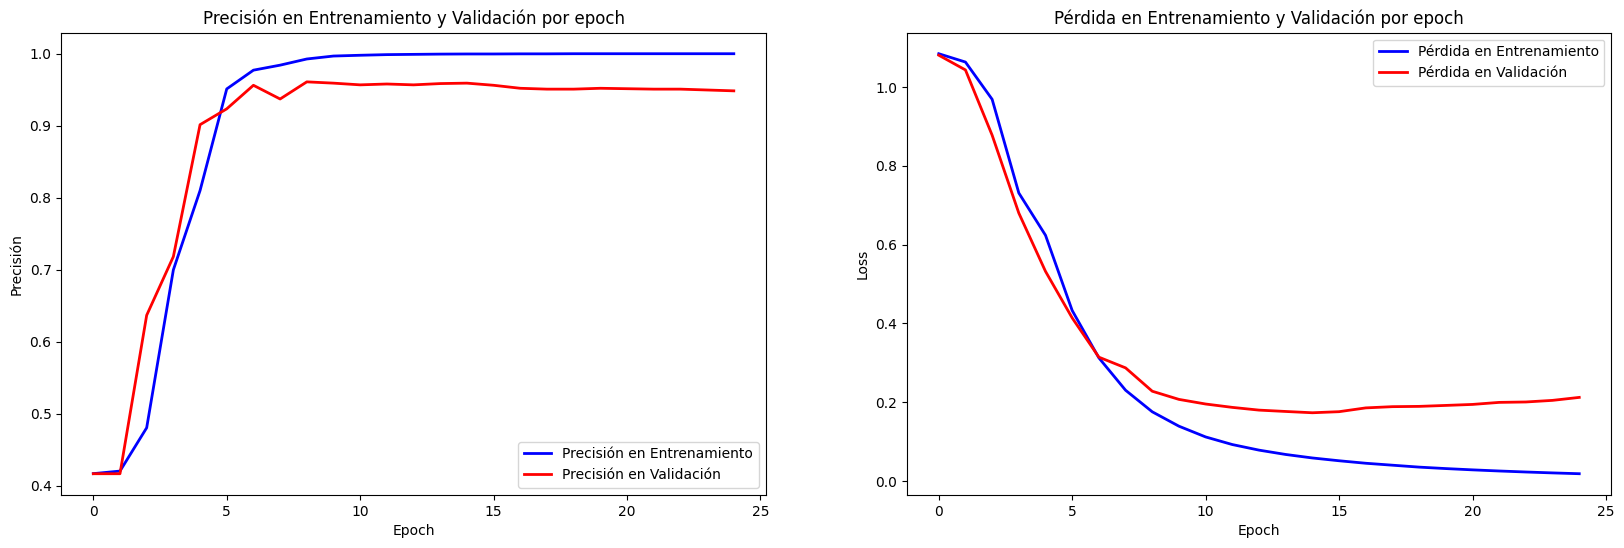

In [31]:
# Usamos la función para evaluarlo
evaluar_modelo(history)

Otra forma de evaluar el modelo es usando el subconjunto de testeo para ver el rendimiento sobre datos nunca vistos durante el entenamiento. Para ello se usa el método `evaluate`.

In [32]:
loss, accuracy = model.evaluate(test_padded_seq,
                                test_label_seq)

23/23 [==============================] - 5s 228ms/step - loss: 0.2192 - accuracy: 0.9473


## Predicciones


Una vez que tenemos el modelo entrenado y con buen rendimiento, queremos hacer predicciones sobre nuevos textos para obtener la categoría a la cual pertenecen.

Previamente a hacer la predicción, es necesario acondicionar esos textos con la mismas características con las que acondicionamos los datos de entrenamiento. Para ello, debemos pasar los textos por la función `procesar_textos`.

Luego, se utiliza la función `preprocesar_predecir` que aplica la función anterior y realiza la predicción sobre ese texto.

In [33]:
def preprocesar_textos(text):
    '''
    Realiza el acondicionamiento de textos para poder hacer predicciones sobre ellos usando el modelo entrenado previamente
    '''
    # Convertir todo a minúsculas
    text = text.lower()

    # Eliminar stopwords, números y signos de puntuación
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and not word.isnumeric()])

    return text

def preprocesar_predecir(new_text, tokenizer, padding, maxlen, model, categorias):
    '''
    Realiza el preprocesamiento del texto nuevo y luego la predicción de la categoría a la cual pertenece
    '''
    # Preprocesar el nuevo texto
    preprocessed_text = preprocesar_textos(new_text)

    # Cargar la lista de archivos de peso
    weight_files = tf.keras.models.load_model('modelo/pesos_modelo.h5')

    # Cargar los pesos guardados del modelo
    model.load_weights(weight_files)

    # Tokenizar y codificar el texto
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen, padding=padding, truncating='post')

    # Realiza la predicción (clacula las probabilidades para cada categoría)
    prediction = model.predict(padded_sequence)[0]
    print('Probabilidades de la predicción:', prediction)

    # Muestra la etiqueta de la predicción
    predicted_label = categorias[prediction.argmax()]
    print('Etiqueta de la predicción:', predicted_label)

    return prediction

Generamos una lista de nuevos textos a las cuales les realizaremos las predicciones.

In [34]:
# Nuevos textos a predecir
new_texts = ["The word meteorology is from the Ancient Greek.",
            "Atmospheric chemistry is a branch of atmospheric science in which the chemistry of the Earth's atmosphere and that of other planets is studied",
            "Rainbows can be full circles. However, the observer normally sees only an arc formed by illuminated droplets above the ground,[3] and centered on a line from the Sun to the observer's eye",
            "Sport is generally recognised as system of activities based in physical athleticism",
            "Two teams of usually between 11 and 18 players; some variations that have fewer players (five or more per team) are also popular",
            "The game occurs over the course of several plays, with each play generally beginning when a player on the fielding team, called the pitcher, throws a ball that a player on the batting team, called the batter, tries to hit with a bat.",
            "There are generally two types of cells: eukaryotic cells, which contain a nucleus, and prokaryotic cells, which do not",
            "Meanwhile, taxonomy and classification became the focus of natural historians. Carl Linnaeus published a basic taxonomy for the natural world in 1735, and in the 1750s introduced scientific names for all his species",
            "Eukaryotic cells contain membrane-bound organelles such as the nucleus, the endoplasmic reticulum, and the Golgi apparatus."]


In [35]:
# Usamos un ciclo for para analizar todos los textos de una vez
for new_text in new_texts:
  print(new_text)
  new_text_prep = preprocesar_textos(new_text)
  preprocesar_predecir(new_text_prep, tokenizer, padding, max_length, model, categorias)
  print('')

The word meteorology is from the Ancient Greek.
1/1 [==============================] - 2s 2s/step
Probabilidades de la predicción: [0.75623626 0.09512137 0.14864238]
Etiqueta de la predicción: Meteorology

Atmospheric chemistry is a branch of atmospheric science in which the chemistry of the Earth's atmosphere and that of other planets is studied
1/1 [==============================] - 0s 103ms/step
Probabilidades de la predicción: [0.75864047 0.1522381  0.08912137]
Etiqueta de la predicción: Meteorology

Rainbows can be full circles. However, the observer normally sees only an arc formed by illuminated droplets above the ground,[3] and centered on a line from the Sun to the observer's eye
1/1 [==============================] - 0s 85ms/step
Probabilidades de la predicción: [0.75286317 0.07544558 0.1716913 ]
Etiqueta de la predicción: Meteorology

Sport is generally recognised as system of activities based in physical athleticism
1/1 [==============================] - 0s 115ms/step
Proba